In [9]:
pip install pyfasta seaborn pandas

SyntaxError: invalid syntax (<ipython-input-9-6af37266e80e>, line 1)

In [45]:
from pyfasta import Fasta
import seaborn as sns
import pandas as pd
import matplotlib.pylab as plt

0 minia 0 cs.gc 18544 cs.gc.cv assemblies


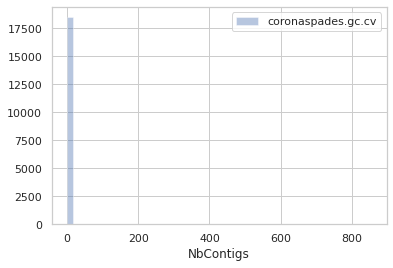

In [46]:
import glob
import os


assemblies = glob.glob("/home/rayan/serratus-assemblies/*.fa")
minia, coronaspades, coronaspades_gc, coronaspades_gc_cv = [], [], [], []
for assembly in assemblies:
    assembly = assembly
    if "coronaspades.checkv_filtered" in assembly:
        coronaspades += [assembly]
    elif "minia.checkv_filtered" in assembly:
        minia += [assembly]
    elif "coronaspades.gene_clusters.fa" in assembly:
        coronaspades_gc += [assembly]
    elif "coronaspades.gene_clusters.checkv_filtered.fa" in assembly:
        coronaspades_gc_cv += [assembly]

# focusing on gc_cv
minia, coronaspades_gc = [],[]

print(len(minia),"minia",len(coronaspades_gc),"cs.gc",len(coronaspades_gc_cv),"cs.gc.cv assemblies")

data_to_insert = []
for assemblies,assembler in [
                             #(minia,'miniak31.cv'),
                             #(coronaspades,'coronaspades.cv'),
                             #(coronaspades_gc,'coronaspades.gc')
                             (coronaspades_gc_cv,'coronaspades.gc.cv'),
                            ]:
    for assembly in assemblies:
        if os.stat(assembly).st_size == 0:
            nb_contigs = 0
            total_length = 0
        else:
            f = Fasta(assembly)
            nb_contigs = len(f.keys())
            total_length = sum([len(f[key]) for key in f.keys()])
        category = 'D'
        if   total_length > 25000  and nb_contigs == 1:
            category = 'A'
        elif total_length > 25000  and nb_contigs > 1:
            category = 'B'
        elif total_length > 5000 and total_length <= 25000:
            category = 'C'
        elif nb_contigs == 0:
            category = 'E'
        data_to_insert += [(assembly.replace('/home/rayan/serratus-assemblies/',''), 
                            assembler, nb_contigs, total_length, category)]
        
data = pd.DataFrame(data_to_insert, columns=['Assembly', 'Assembler', 'NbContigs', 'TotalLength', 'Category'])

sns.set(style="whitegrid")
#sns.distplot(data[data['Assembler'] == 'miniak31.cv']['NbContigs'], kde=False, rug=True, label="miniak31.cv");
#sns.distplot(data[data['Assembler'] == 'coronaspades.cv']['NbContigs'], kde=False, rug=True, label="coronaspades.cv");
#sns.distplot(data[data['Assembler'] == 'coronaspades.gc']['NbContigs'], kde=False, label="coronaspades.gc");
sns.distplot(data[data['Assembler'] == 'coronaspades.gc.cv']['NbContigs'], kde=False, label="coronaspades.gc.cv");
plt.legend()

data.to_csv('data.csv')



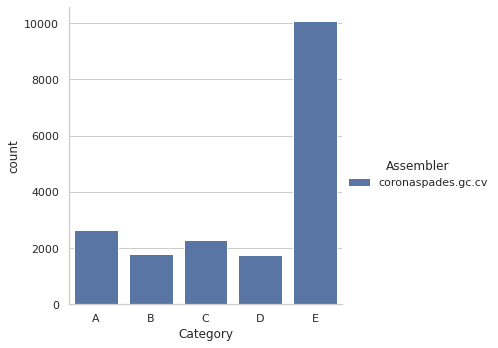

In [47]:
sns.catplot(x="Category", kind="count", order=('A','B','C','D','E'), data=data, hue='Assembler');

In [59]:
version = 3
def produce_cat(category):
    cat_gc_cv = list(map(lambda x: 's3://serratus-public/assemblies/contigs/' + x, 
             list(data[
                 (data['Assembler'] == 'coronaspades.gc.cv') 
                 & 
                 (data['Category'] == category) ]['Assembly'])))
    f = open("cat%s-v%d.txt" % (category,version),"w")
    print(len(cat_gc_cv),"cat%s saved"%category)
    for l in cat_gc_cv:
        f.write(l+"\n")
    f.close()
    f = open("cat%s-v%d.accessions.txt" % (category,version),"w")
    for l in cat_gc_cv:
        f.write(l.replace('s3://serratus-public/assemblies/contigs/','')
                .replace('.coronaspades.gene_clusters.checkv_filtered.fa','')
                +"\n")
    f.close()
    f = open("cat%s-v%d.fa" % (category,version),"w")
    for l in cat_gc_cv:
        filename = l.replace('s3://serratus-public/assemblies/contigs/','')
        g = Fasta("/home/rayan/serratus-assemblies/" + filename)
        for key in g.keys():
            contig = g[key]
            accession = filename.replace('.coronaspades.gene_clusters.checkv_filtered.fa','')
            f.write(">%s\n" % (str(key)))
            f.write(str(contig) + "\n")
    f.close()
for category in ['A','B','C']:
    produce_cat(category)

2643 catA saved
1773 catB saved
2289 catC saved
